# Time Series Analysis

**Contents**

1. Data ETL | Processing
2. Modeling

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from darts.timeseries import TimeSeries

from components import config
from components.ts_logger import logger
from components.utils import get_csv_dataframe

## 1. Data ETL | Processing


### Parse CSV Data

In [11]:
energy_load = [
    config.io_paths["DATASET_EC_LOAD_17"],
    config.io_paths["DATASET_EC_LOAD_18"],
    config.io_paths["DATASET_EC_LOAD_19"],
]

air_temperature = [
    config.io_paths["DATASET_TEMP_AIR_17"],
    config.io_paths["DATASET_TEMP_AIR_18"],
    config.io_paths["DATASET_TEMP_AIR_19"],
]

load_df = pd.concat([
    pd.read_csv(
        energy_load[i], index_col=[0], skiprows=[1],
    ) for i in range(len(energy_load))
])
temp_df = pd.concat([
    pd.read_csv(
        air_temperature[i], index_col=[0], skiprows=[1]
    ) for i in range(len(air_temperature))
])
logger.info(">> dataset loaded 2017-2019 and concatenated")

load_df.index = pd.to_datetime(load_df.index)
load_df = load_df.resample('H').sum(min_count=1)
logger.info(">> dataset resampled to hourly")

# load_df["Temperature"] = temp_df["value"].to_list()
# load_df = load_df[["Load", "Temperature"]]
# logger.info(">> hourly temperature added to dataframe")

load_series = TimeSeries.from_dataframe(load_df)
logger.info(">> darts time series of type {} created".format(load_series.__class__.__name__))

load_series.tail(5)

2024-01-26 16:36:17 [info     ] >> dataset loaded 2017-2019 and concatenated
2024-01-26 16:36:18 [info     ] >> dataset resampled to hourly


The provided DatetimeIndex was associated with a timezone, which is currently not supported by xarray. To avoid unexpected behaviour, the tz information was removed. Consider calling `ts.time_index.tz_localize(UTC)` when exporting the results.To plot the series with the right time steps, consider setting the matplotlib.pyplot `rcParams['timezone']` parameter to automatically convert the time axis back to the original timezone.


2024-01-26 16:36:18 [info     ] >> darts time series of type TimeSeries created


<TimeSeries (DataArray) (Date (UTC): 5, component: 1, sample: 1)>
array([[[208132.8]],

       [[195995.3]],

       [[188942.4]],

       [[187248.1]],

       [[179641. ]]])
Coordinates:
  * Date (UTC)  (Date (UTC)) datetime64[ns] 2019-12-31T18:00:00 ... 2019-12-3...
  * component   (component) object 'Load'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

## 2. Modeling

In [15]:
train_set, valid_set = load_series.split_after(int(0.9 * len(load_series)))

In [16]:
from darts.models import (
    NaiveSeasonal,
    ExponentialSmoothing,
    ARIMA,
    AutoARIMA
)
from darts.utils.utils import (
    ModelMode,
    SeasonalityMode
)
from darts.metrics import mape


2024-01-26 16:37:08 [info     ] >> fit NaiveSeasonal model
2024-01-26 16:37:08 [info     ] >> predict with valid set
2024-01-26 16:37:08 [info     ] >> Mean average percentage error: 11.027996265813092


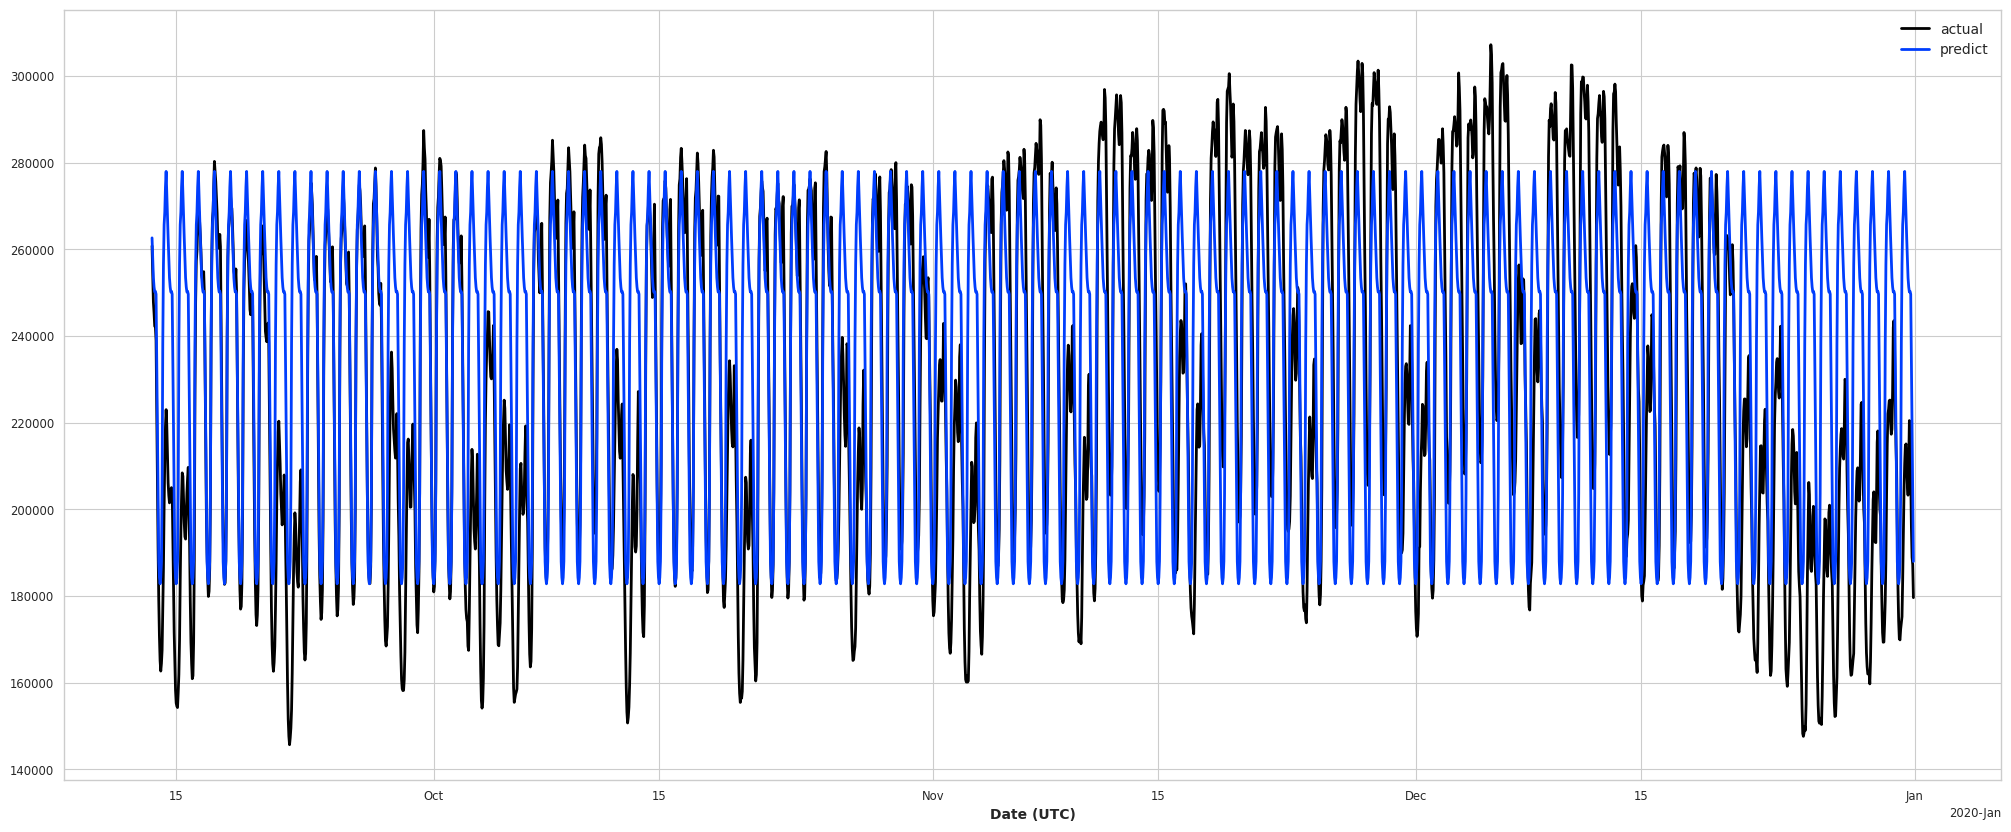

In [17]:
load_model = NaiveSeasonal(K=24) #daily seasonality
load_model.fit(train_set)
logger.info(">> fit NaiveSeasonal model")

prediction = load_model.predict(len(valid_set))
logger.info(">> predict with valid set")

valid_set.plot(label='actual')
prediction.plot(label='predict', low_quantile=0.05, high_quantile=0.95)
plt.legend()


logger.info(">> Mean average percentage error: {}".format(mape(valid_set, prediction)))

/home/mnpr/miniforge3/envs/timeseries/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


2024-01-26 16:38:51 [info     ] >> fit NaiveSeasonal model
2024-01-26 16:38:52 [info     ] >> predict with valid set
2024-01-26 16:38:52 [info     ] >> Mean average percentage error: 54.80347330453538


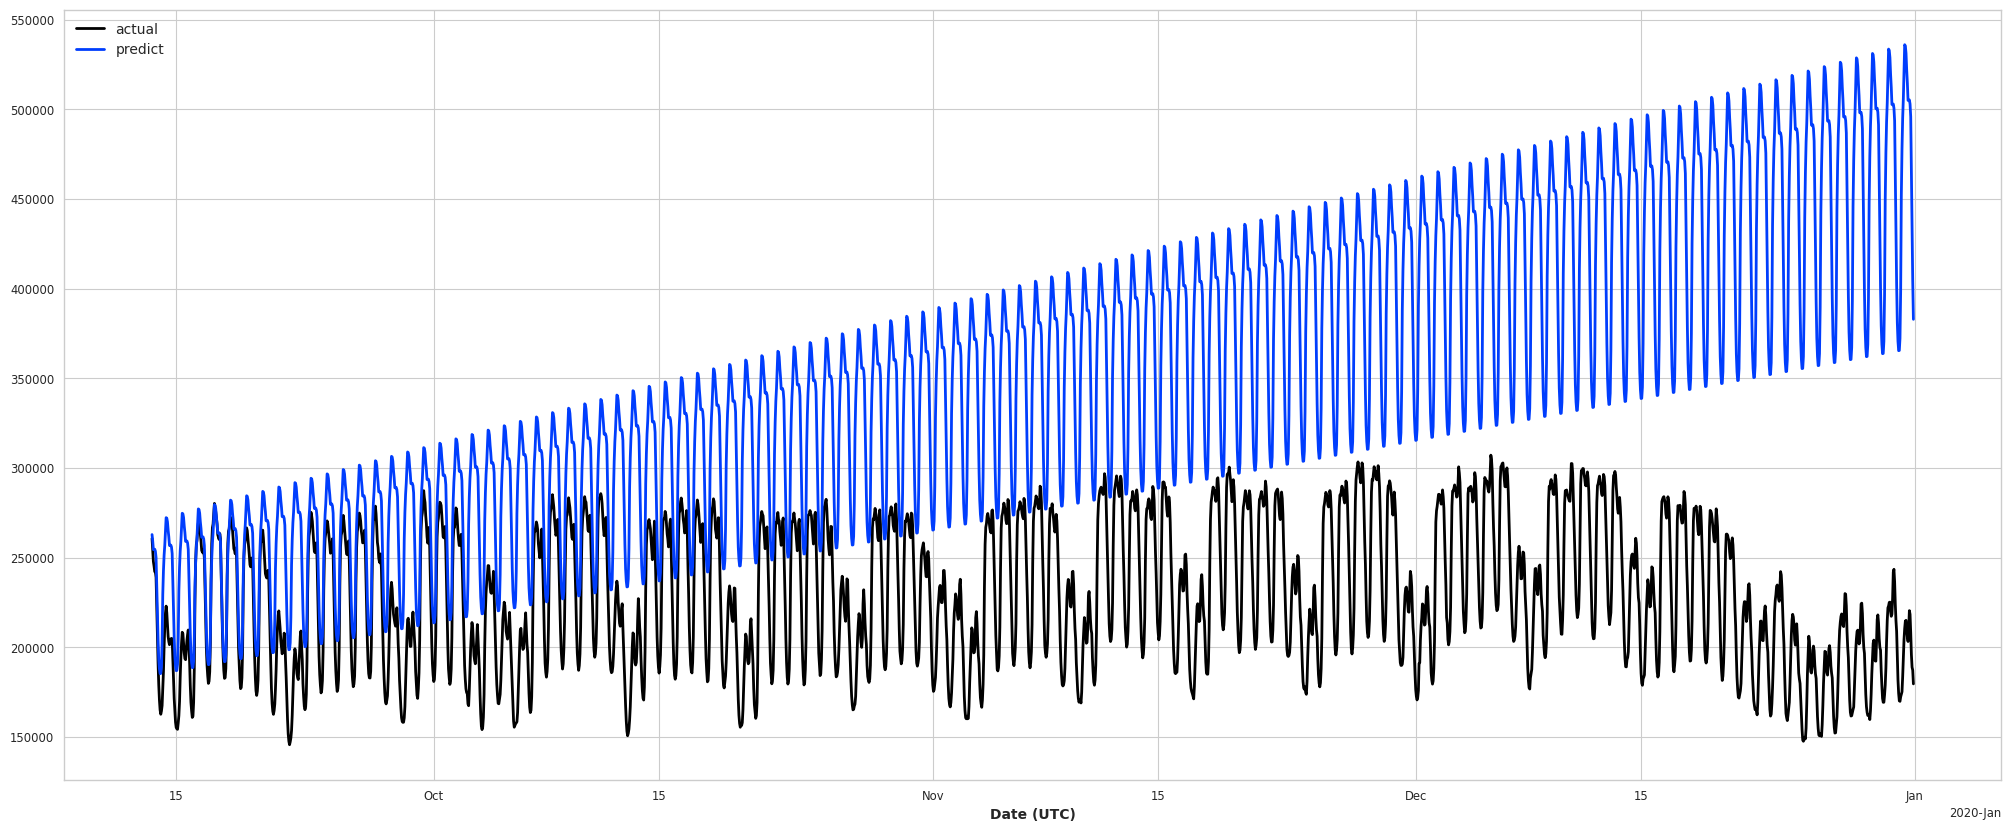

In [21]:
#holz winter
load_model = ExponentialSmoothing(
    trend=ModelMode.ADDITIVE,
    seasonal=SeasonalityMode.MULTIPLICATIVE
)
load_model.fit(train_set)
logger.info(">> fit NaiveSeasonal model")

prediction = load_model.predict(len(valid_set))
logger.info(">> predict with valid set")

valid_set.plot(label='actual')
prediction.plot(label='predict', low_quantile=0.05, high_quantile=0.95)
plt.legend()

logger.info(">> Mean average percentage error: {}".format(mape(valid_set, prediction)))